# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Загрузим данные и посмотрим на первые строки:

In [2]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Узнаем количество данных в датасете и типы данных в разных столбцах:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Сохраним количество наблюдений в датасете в переменную `size`:

In [4]:
size = len(df)
size

354369

Оставим только те столбцы, которые пригодятся для обучения модели:

In [5]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Посмотрим, сколько пропусков в датасете и в каких столбцах есть пропущенные значения:

In [6]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

Больше всего пропусков в столбце `NotRepaired`. Посмотрим, как распределены данные в этом столбце:

In [7]:
df.NotRepaired.value_counts(dropna = False, normalize = True)

no     0.697468
NaN    0.200791
yes    0.101741
Name: NotRepaired, dtype: float64

70% авто не были в серьезном ремонте и только 10% были, а про остальные 20% информация не предоставлена. Эта информация важна для предсказания цены, и все автовладельцы это понимают: машины, побывавшие в авариях, стоят дешевле. 

Если автовладелец не указал эту информацию, будем по умолчанию считать, что автомобиль "не бит, не крашен". 

А если "бит и крашен", то, умалчивая об этой информации, автовладелец, скорее всего, понимает, что при продаже этот факт выяснится, и реальная цена, по которой он сможет продать машину, вероятно, будет отличаться от предсказанной сервисом (в меньшую сторону).

In [8]:
df.NotRepaired = df.NotRepaired.fillna('no')
df.NotRepaired.value_counts(dropna = False, normalize = True)

no     0.898259
yes    0.101741
Name: NotRepaired, dtype: float64

Около 5,5% объектов в датасете содержат пропуски в столбце с моделью авто. Можно предположить, что один из ключевых признаков для предсказания цены: машины одной модели одного года выпуска, скорее всего, будут стоить примерно одинаково. 

Но угадать модель на основе других данных об автомобиле - сложная задача, а ошибка приведет к ошибкам в работе нашей модели. 

Так что лучше избавимся от объектов, для которых не указана модель, тем более, что датасет довольно большой и потеря 5% от него не критична.

Правда, есть еще и объекты, где модель не отсутствует, а обозначена как "other". Возможно, это редкие модели или модели, названия которых указали с ошибками. В любом случае, такое значение модели не информативно и вряд ли поможет обучению модели.

Посмотрим, сколько в датасете таких объектов.

In [9]:
df[(df.Model.isna()) | (df.Model == 'other')].Model.count() / size * 100

6.891404157812901

В общей сложности (пропусков и "other") - чуть менее 7%. Не так уж много; удалим эти объекты.

In [10]:
df.drop(df[(df.Model.isna()) | (df.Model == 'other')].index, inplace = True)

Много пропусков в столбце `VehicleType`:

In [11]:
df.VehicleType.value_counts(dropna = False, normalize = True)

sedan          0.266562
small          0.235264
wagon          0.195698
NaN            0.092840
bus            0.076131
convertible    0.057655
coupe          0.040239
suv            0.028897
other          0.006714
Name: VehicleType, dtype: float64

Тип кузова зависит от модели. Значит, можно заполнить пропуски в столбце с типом кузова, опираясь на тип кузова, указанный для других авто той же модели. 

Правда, выясняется, что для одной и той же модели могут указывать разные типы кузова.

In [12]:
df.groupby('Model').VehicleType.value_counts()

Model   VehicleType
100     sedan          278
        wagon          109
        coupe            2
        convertible      1
145     small           19
                      ... 
zafira  sedan           22
        small           11
        suv              7
        convertible      1
        coupe            1
Name: VehicleType, Length: 1123, dtype: int64

Положимся на мнение большинства: для каждой модели найдем наиболее часто встречающееся значение в столбце с типом кузова.

Но сначала проверим, все ли названия моделей уникальны. Оказывается, не все. 8 названий моделей относятся более чем к 1 бренду. Сохраним их в переменную `not_unique_models`:

In [13]:
not_unique_models = df.groupby('Model').Brand.nunique().sort_values(ascending = False).head(8).index.to_list()

Посмотрим, что это за модели и к каким брендам они относятся:

In [14]:
df[df.Model.isin(not_unique_models)].groupby(['Model', 'Brand']).Brand.count()

Model       Brand     
1_reihe     mazda          100
            peugeot       1206
3_reihe     mazda         1322
            peugeot       2171
5_reihe     mazda          329
            peugeot        113
defender    land_rover      75
            rover            1
discovery   land_rover      77
            rover            2
freelander  land_rover     215
            rover            3
grand       chrysler       110
            jeep           241
            suzuki         210
matiz       chevrolet      284
            daewoo         159
Name: Brand, dtype: int64

В случае с 3 моделями Land Rover проблему можно решить, переименовав бренд "rover" в "land_rover":

In [15]:
df.loc[df.Brand == 'rover', 'Brand'] = 'land_rover'

Остальные модели из списка неуникальных названий моделей переименуем, добавив к названию модели название соответствующего бренда:

In [16]:
def model_brand(row):
    model_brand = row['Model'] + ' ' + row['Brand']
    return model_brand

In [17]:
df.loc[(df.Model.isin(not_unique_models)) & (df.Brand.isin(['mazda', 'peugeot', 'chrysler', 'jeep', 'suzuki', 'chevrolet', 'daewoo'])), 'Model'] = df.loc[(df.Model.isin(not_unique_models)) & (df.Brand.isin(['mazda', 'peugeot', 'chrysler', 'jeep', 'suzuki', 'chevrolet', 'daewoo']))].apply(model_brand, axis = 1)

Теперь можем для каждой уникальной модели найти наиболее часто встречающееся значение в столбце `VehicleType` (тип кузова). Сохраним это значение в новый столбец `VType` и используем для замены пропусков в столбце с типом кузова. После замены удалим новый столбец `VType`:

In [18]:
vtm = {}
for i in df.Model.values:
    if i not in vtm:
        vt = df[df.Model == i].VehicleType.value_counts().index[0]
        vtm[i] = vt

In [19]:
df['VType'] = df.Model.map(vtm)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,VType
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,no,sedan
2,9800,suv,2004,auto,163,grand jeep,125000,gasoline,jeep,no,suv
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,sedan
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,small
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,sedan


In [20]:
df.loc[(df.VehicleType.isna()) | (df.VehicleType == 'other'), 'VehicleType'] = df.loc[(df.VehicleType.isna()) | (df.VehicleType == 'other'), 'VType']

In [21]:
df.VehicleType.value_counts()

sedan          95777
small          81915
wagon          64470
bus            27561
convertible    18159
coupe          12898
suv             9456
other              7
Name: VehicleType, dtype: int64

In [22]:
df.drop('VType', axis = 1, inplace = True)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand jeep,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Посмотрим, как обстоят дела с пропусками в столбцах `FuelType` (тип топлива) и `Gearbox` (тип коробки передач):

In [23]:
df.FuelType.value_counts(dropna = False, normalize = True)

petrol      0.616846
gasoline    0.290163
NaN         0.076627
lpg         0.013873
cng         0.001641
hybrid      0.000425
other       0.000335
electric    0.000090
Name: FuelType, dtype: float64

In [24]:
df.Gearbox.value_counts(dropna = False, normalize = True)

manual    0.767160
auto      0.186728
NaN       0.046112
Name: Gearbox, dtype: float64

Пропусков довольно много, но восстановить пропущенные значения на основе данных в других столбцах будет сложно:

In [25]:
df.groupby('Model').FuelType.nunique().sort_values(ascending = False)

Model
golf                  7
astra                 7
e_klasse              7
c_klasse              6
3er                   6
                     ..
amarok                1
materia               1
90                    1
911                   1
range_rover_evoque    1
Name: FuelType, Length: 255, dtype: int64

В обоих случаях есть заметный перевес в сторону наиболее частого значения признака: почти 77% авто - с ручной коробкой передач и почти 62% машин работают на бензине. При этом кажется, что оба фактора не очень сильно влияют на рыночную цену автомобиля. Поэтому заменим отсутствующие значения наиболее распространенными: если значение пропущено, то будем по умолчанию считать, что коробка передач - ручная, а тип топлива - бензин.

In [26]:
df.loc[df.FuelType.isna(), 'FuelType'] = 'petrol'
df.loc[df.FuelType == 'other', 'FuelType'] = 'petrol'

In [27]:
df.FuelType.value_counts(dropna = False, normalize = True)

petrol      0.693808
gasoline    0.290163
lpg         0.013873
cng         0.001641
hybrid      0.000425
electric    0.000090
Name: FuelType, dtype: float64

In [28]:
df.Gearbox = df.Gearbox.fillna('manual')

In [29]:
df.Gearbox.value_counts(dropna = False, normalize = True)

manual    0.813272
auto      0.186728
Name: Gearbox, dtype: float64

Теперь проверим распределение целевого признака (цены):

In [30]:
df.Price.describe()

count    310243.000000
mean       4511.317122
std        4519.368948
min           0.000000
25%        1150.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

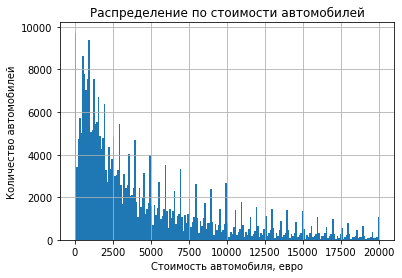

In [31]:
df.Price.hist(bins = 200)
plt.xlabel('Стоимость автомобиля, евро')
plt.ylabel('Количество автомобилей')
plt.title('Распределение по стоимости автомобилей');

В целом распределение выглядит правдоподобно: медиана на уровне 2850 евро, длинный хвост гораздо более дорогих машин. 

Но от нулей точно нужно избавиться. Да и очень дешевые машины вызывают вопросы:

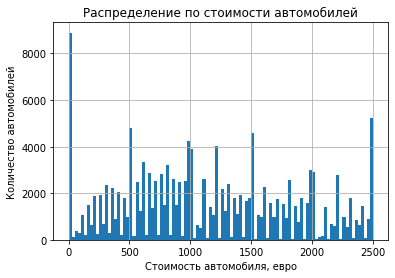

In [32]:
df.Price.hist(bins = 100, range = (0, 2500))
plt.xlabel('Стоимость автомобиля, евро')
plt.ylabel('Количество автомобилей')
plt.title('Распределение по стоимости автомобилей');

In [33]:
df[(df.Price > 1) & (df.Price < 400)].RegistrationYear.value_counts().head()

1997    1912
2000    1824
1995    1636
1998    1556
1996    1497
Name: RegistrationYear, dtype: int64

In [34]:
df[(df.Price > 1) & (df.Price < 400)].groupby('Model').Brand.value_counts().sort_values(ascending = False).head(10)

Model   Brand     
corsa   opel          1822
polo    volkswagen    1517
golf    volkswagen    1456
fiesta  ford           809
astra   opel           775
twingo  renault        756
ka      ford           555
3er     bmw            441
vectra  opel           430
mondeo  ford           405
Name: Brand, dtype: int64

In [35]:
df[(df.Price > 1) & (df.Price < 400)].NotRepaired.value_counts(normalize = True)

no     0.676899
yes    0.323101
Name: NotRepaired, dtype: float64

В целом, похоже на правду: недорогие модели возрастом старше 15 лет, и каждый третий автомобиль "бит и крашен".

Удалим совсем уж неправдоподобные по цене предложения (дешевле 250 евро), а остальные оставим.

In [36]:
len(df[df.Price < 250]) / size * 100

4.307656708120631

Придется расстаться еще с 4% исходного датасета, но ничего не поделаешь: наблюдения без целевого признака нам не нужны.

In [37]:
df.drop(df[df.Price < 250].index, inplace = True)

Проверим на выбросы данные в других столбцах:

In [38]:
df.RegistrationYear.describe()

count    294978.000000
mean       2004.071999
std          49.644933
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

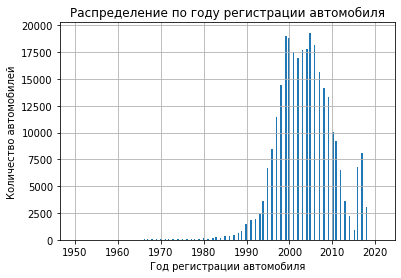

In [39]:
df.RegistrationYear.hist(range = (1950, 2021), bins = 50)
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество автомобилей')
plt.title('Распределение по году регистрации автомобиля');

Избавимся от аномальных значений: объектов, для которых указан год выпуска ранее 1960 г. или позже 2016 г. (т.к. данные выгружены в начале 2016 г.).

In [40]:
len(df[(df.RegistrationYear < 1960) | (df.RegistrationYear > 2016)]) / size * 100

3.1834048689360523

Это примерно 3% от исходного датасета.

In [41]:
df.drop(df[(df.RegistrationYear < 1960) | (df.RegistrationYear > 2016)].index, inplace = True)

In [42]:
df.Kilometer.describe()

count    283697.000000
mean     128809.539755
std       36415.570322
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Аномальных значений пробега нет, хотя распределение признака вызывает вопросы. Вероятно, пробег более 150 000 км не учитывается (указывается как "более 150 тыс.км.").

In [43]:
df.Power.describe()

count    283697.000000
mean        114.072239
std         182.499495
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Самые быстрые машины в мире имеют мощность 1500-1600 лошадиных сил. Возможно, кто-то ошибся ноликом. Или двумя.

In [44]:
df[df.Power > 600].groupby(['Model', 'Brand', 'Power']).Power.count().sort_values(ascending = False).head(15)

Model            Brand          Power
a_klasse         mercedes_benz  1400     3
vectra           opel           1800     3
passat           volkswagen     1403     2
polo             volkswagen     601      2
transporter      volkswagen     10522    2
golf             volkswagen     1011     2
                                1595     2
transporter      volkswagen     1021     2
golf             volkswagen     1781     2
polo             volkswagen     4700     2
                                1390     2
3er              bmw            1500     2
matiz chevrolet  chevrolet      603      2
astra            opel           1001     2
3er              bmw            1103     2
Name: Power, dtype: int64

In [45]:
df[df.Power > 600].groupby(['Model', 'Brand', 'Power']).Power.count().sum() / size * 100

0.07393423239617461

Здесь явно ошибки: эти модели не могут иметь такой мощности. 

Желательно выяснить, из-за чего могут возникать такие ошибки, и придумать алгоритм по их устранению (например, проверять значения этого признака на адекватность и исправлять аномалии, ориентируясь на мощность других машин той же модели, как мы делали в случае с типом кузова). 

В нашем случае таких ошибок немного, просто удалим эти аномалии.

In [46]:
df.drop(df[df.Power > 600].index, inplace = True)

Посмотрим на более правдоподобные значения мощности: от 300 до 600 л.с.:

In [47]:
df[(df.Power > 300) & (df.Power <= 600)].groupby(['Model', 'Brand', 'Power']).Power.count().sort_values(ascending = False).head(50)

Model     Brand          Power
3er       bmw            306      115
cayenne   porsche        340      102
e_klasse  mercedes_benz  306      101
s_klasse  mercedes_benz  306       89
sl        mercedes_benz  306       76
cl        mercedes_benz  306       72
touareg   volkswagen     313       62
7er       bmw            333       62
6er       bmw            333       61
a8        audi           334       49
m_reihe   bmw            343       40
7er       bmw            326       40
m_klasse  mercedes_benz  306       37
clk       mercedes_benz  306       34
5er       bmw            333       33
7er       bmw            306       32
cayenne   porsche        450       30
a8        audi           326       29
                         310       28
e_klasse  mercedes_benz  476       27
phaeton   volkswagen     313       24
e_klasse  mercedes_benz  354       24
7er       bmw            329       24
a6        audi           334       23
a4        audi           310       23
s_klasse  mercedes_

А вот здесь уже представлены модели, для которых указанное количество лошадиных сил кажется правдоподобным. О том, что цифры достоверны, свидетельствует и количество наблюдений с соответствующим показателем мощности автомобиля.

Нужно избавиться и от аномально низких значений. К сожалению, таких много: только нулей больше 6,5% от исходного датасета.

In [48]:
len(df[df.Power == 0]) / size * 100

6.567165863831203

Заменим нули наиболее часто встречающимся значением мощности для каждой модели:

In [49]:
mp = {}
for i in df.Model.values:
    if i not in mp:
        p = df[df.Model == i].Power.value_counts().index[0]
        mp[i] = p
        if p == 0:
            try:
                p1 = df[df.Model == i].Power.value_counts().index[1]
                mp[i] = p1
            except:
                mp[i] = p

In [50]:
df['MPower'] = df.Model.map(mp)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,MPower
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no,75
2,9800,suv,2004,auto,163,grand jeep,125000,gasoline,jeep,no,218
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,75
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,75
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,150


In [51]:
df.loc[df.Power == 0, 'Power'] = df.loc[df.Power == 0, 'MPower']

Проверим, все ли нули удалось заменить:

In [52]:
df.loc[df.Power == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,MPower
234296,3800,wagon,1978,manual,0,serie_1,30000,gasoline,land_rover,no,0


Удалим этот объект:

In [53]:
df.drop(234296, inplace = True)

С нулями разобрались, исключим также аномально низкие значения мощности:

In [54]:
df[df.Power < 20].groupby(['Model', 'Brand', 'Power']).Power.count().sort_values(ascending = False)

Model            Brand       Power
500              fiat        18       42
                             15        3
                             19        2
polo             volkswagen  6         2
3er              bmw         11        2
                                      ..
golf             volkswagen  8         1
                             1         1
freelander       land_rover  12        1
fortwo           smart       5         1
1_reihe peugeot  peugeot     7         1
Name: Power, Length: 72, dtype: int64

In [55]:
df.drop(df[df.Power < 20].index, inplace = True)

In [56]:
df.drop('MPower', axis = 1, inplace = True)

In [57]:
len(df) / size * 100

79.94830247566802

Пришлось выбросить около 20% датасета. Зато модель будет обучаться на относительно чистых данных и сможет показать лучший результат.

Осталось подготовить признаки к обучению моделей.

Разделим датасет на признаки и целевой признак, а также на обучающую и тестовую выборку, выполним кодирование категориальных и масштабирование числовых признаков.

In [58]:
#кодирование категориальных признаков
data = pd.get_dummies(df, drop_first=True)

#выделение признаков и целевого признака
X = data.drop('Price', axis=1)
y = data['Price']
#разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
 
#масштабирование числовых признаков
num_col = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(X_train[num_col])
X_train.loc[:, num_col] = scaler.transform(X_train.loc[:, num_col])
X_test.loc[:,num_col] = scaler.transform(X_test.loc[:, num_col])

In [59]:
#сохраним список категориальных признаков
cat_col = list(df.loc[:, df.dtypes == 'object'].columns.values)
cat_col

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

## Обучение моделей

### Модель случайного леса

In [60]:
%%time

# создадим модель случайного леса
ranfor = RandomForestRegressor(random_state = 123)

# создадим словарь для подбора оптимальных гиперпараметров
params = {'max_depth': range(22, 38, 5)}

# используем GridSearchCV для подбора оптимальных гиперпараметров модели в процессе кросс-валидации
rf = GridSearchCV(ranfor, param_grid = params, scoring = 'neg_mean_squared_error', cv = 3, n_jobs = -1)

# обучим модель и выведем оптимальную глубину дерева и наилучший RMSE на кросс-валидации
rf.fit(X_train, y_train)

print('Оптимальная глубина дерева:', rf.best_params_['max_depth'])
print('Лучший RMSE на кросс-валидации:', abs(rf.best_score_) ** 0.5)

# получим предсказания модели на тестовой выборке и посчитаем RMSE
rf_pred = rf.predict(X_test)
print('RMSE на тестовой выборке:', mean_squared_error(y_test, rf_pred) ** 0.5)

Оптимальная глубина дерева: 27
Лучший RMSE на кросс-валидации: 1572.1793512989188
RMSE на тестовой выборке: 1516.3935028230462
CPU times: user 6min 48s, sys: 3.59 s, total: 6min 51s
Wall time: 6min 54s


**Случайный лес:**
    
Оптимальная глубина дерева: 27

Лучший RMSE на кросс-валидации: 1572.559371245903

RMSE на тестовой выборке: 1517.062872003245

CPU times: user 7min 53s, sys: 0 ns, total: 7min 53s

Wall time: 8min 6s

Выясним значимость разных признаков в полученной модели:

In [61]:
fimp = round(pd.Series(rf.best_estimator_.feature_importances_, index = X_train.columns), 4)

In [62]:
fimp.sort_values(ascending = False).head(10)

RegistrationYear           0.5462
Power                      0.2624
Kilometer                  0.0536
VehicleType_convertible    0.0155
Model_transporter          0.0122
NotRepaired_yes            0.0100
Gearbox_manual             0.0062
Brand_audi                 0.0054
Brand_volkswagen           0.0054
VehicleType_wagon          0.0046
dtype: float64

С наиболее значимыми признаками (числовыми) все ясно, но как оценить вклад таких признаков, как модель, бренд, тип кузова? Из-за проведенного кодирования категориальных признаков сделать это сложно. Объединим показатели, относящиеся к одному и тому же признаку:

In [63]:
imp_f = pd.Series()

for i in cat_col:
    imp_f[i] = round(fimp[fimp.index.str.startswith(i)].sum(), 4)
    
for j in num_col:
    imp_f[j] = round(fimp[fimp.index.str.startswith(j)].sum(), 4)

In [64]:
imp_f = imp_f.sort_values(ascending = False)
imp_f

RegistrationYear    0.5462
Power               0.2624
Kilometer           0.0536
Model               0.0534
Brand               0.0311
VehicleType         0.0294
NotRepaired         0.0100
FuelType            0.0067
Gearbox             0.0062
dtype: float64

Визуализируем полученный результат:

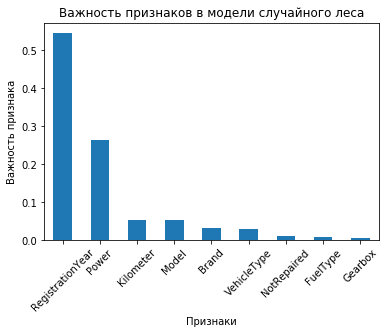

In [65]:
imp_f.plot(kind = 'bar')
plt.title("Важность признаков в модели случайного леса")
plt.xlabel("Признаки")
plt.ylabel("Важность признака")
plt.xticks(rotation = 45);

Наибольшее значение получили такие признаки, как год регистрации и мощность, в меньшей степени - километраж и модель, а также бренд и тип кузова. В целом, выглядит логично.

### Модель линейной регрессии

! Следующая ячейка закомментирована, т.к. код выполняется слишком долго.

In [66]:
# %%time
# lassoreg = Lasso(max_iter = 1000, random_state = 123)
# pars = {'alpha': [0.1, 1]}
# lasso = GridSearchCV(lassoreg, param_grid = pars, scoring = 'neg_mean_squared_error', cv = 3, n_jobs = -1)
# lasso.fit(X_train, y_train)
# print('Лучший RMSE на кросс-валидации:', abs(lasso.best_score_) ** 0.5)
# lasso_pred = lasso.predict(X_test)
# print('RMSE на тестовой выборке:', mean_squared_error(y_test, lasso_pred) ** 0.5)

**Линейная регрессия:**

Лучший RMSE на кросс-валидации: 2497.8934064078244

RMSE на тестовой выборке: 2482.2839808938547

CPU times: user 36min 47s, sys: 16min 15s, total: 53min 3s

Wall time: 53min 4s

Модель обучается слишком долго. Попробуем обучить модель линейной регрессии, используя стохастический градиентный спуск:

In [67]:
%%time

class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features.values), axis=1)        
        y = train_target.values
        w = np.zeros(X.shape[1])
        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]
                
                w -= self.step_size * gradient
 
        self.w = w[1:]
        self.w0 = w[0]
 
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

model = SGDLinearRegression(0.01, 10, 100)
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print('Лучший RMSE на кросс-валидации:', mean_squared_error(y_train, pred_train) ** 0.5)
print('RMSE на тестовой выборке:', mean_squared_error(y_test, pred_test) ** 0.5)

Лучший RMSE на кросс-валидации: 2538.556350706307
RMSE на тестовой выборке: 2519.5387685327964
CPU times: user 42.2 s, sys: 34.9 s, total: 1min 17s
Wall time: 1min 17s


**Линейная регрессия:**

Лучший RMSE на кросс-валидации: 2538.5075893576254

RMSE на тестовой выборке: 2519.4092787117406

CPU times: user 34.2 s, sys: 38.1 s, total: 1min 12s

Wall time: 1min 12s

Теперь модель обучается быстро, но все равно показывает результат значительно хуже, чем случайный лес. Такой результат нас не устраивает.

### Градиентный бустинг (LightGBM)

LightGBM может работать с категориальными признаками напрямую.

Приведем столбцы с категориальными признаками к соответствующему типу и подготовим новые выборки:

In [68]:
df2 = df.copy()
for feature in cat_col:
    df2[feature] = df2[feature].astype("category")
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283312 entries, 0 to 354368
Data columns (total 10 columns):
Price               283312 non-null int64
VehicleType         283312 non-null category
RegistrationYear    283312 non-null int64
Gearbox             283312 non-null category
Power               283312 non-null int64
Model               283312 non-null category
Kilometer           283312 non-null int64
FuelType            283312 non-null category
Brand               283312 non-null category
NotRepaired         283312 non-null category
dtypes: category(6), int64(4)
memory usage: 12.7 MB


In [69]:
#выделение признаков и целевого признака
X_cat = df2.drop('Price', axis=1)
y_cat = df2['Price']
#разделение на обучающую и тестовую выборки
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=12345)

#масштабирование числовых признаков
num_col = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(Xc_train[num_col])
Xc_train.loc[:, num_col] = scaler.transform(Xc_train.loc[:, num_col])
Xc_test.loc[:,num_col] = scaler.transform(Xc_test.loc[:, num_col])

In [70]:
%%time
params = {'learning_rate': [0.1, 0.15], 'n_estimators': [600, 700]}
gbmс = LGBMRegressor(max_depth = 22, num_leaves = 100, random_state = 123, importance_type = 'gain')
gs_gbmс = GridSearchCV(gbmс, param_grid = params, scoring = 'neg_mean_squared_error', cv=3, n_jobs = -1)
gs_gbmс.fit(Xc_train, yc_train)

print('Оптимальные параметры:', gs_gbmс.best_params_)
print('Лучший RMSE:', abs(gs_gbmс.best_score_) ** 0.5)

gs_gbmс_pred = gs_gbmс.predict(Xc_test)
print('RMSE на тестовой выборке:', mean_squared_error(yc_test, gs_gbmс_pred) ** 0.5)

Оптимальные параметры: {'learning_rate': 0.1, 'n_estimators': 700}
Лучший RMSE: 1471.4459412381725
RMSE на тестовой выборке: 1430.3148275298954
CPU times: user 13min 3s, sys: 7.18 s, total: 13min 10s
Wall time: 13min 19s


**LightGBM:**
    
Оптимальные параметры: {'learning_rate': 0.1, 'n_estimators': 700}

Лучший RMSE: 1471.936590026777

RMSE на тестовой выборке: 1428.1429285495979

CPU times: user 14min 30s, sys: 6.58 s, total: 14min 37s

Wall time: 14min 47s

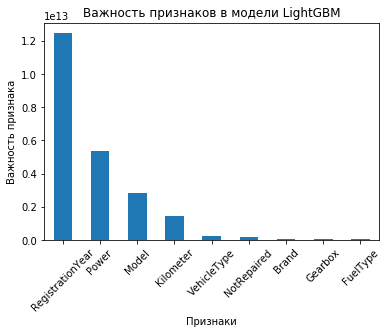

In [71]:
fimpLGBM = round(pd.Series(gs_gbmс.best_estimator_.feature_importances_, index = Xc_train.columns), 4)
    
fimpLGBM = fimpLGBM.sort_values(ascending = False)

fimpLGBM.plot(kind = 'bar')
plt.title("Важность признаков в модели LightGBM")
plt.xlabel("Признаки")
plt.ylabel("Важность признака")
plt.xticks(rotation = 45);

Как видим, распределение важности признаков в целом похоже на распределение в случае с моделью случайного леса. Но степень важности разных признаков отличается. Самые значимые признаки - год регистрации и мощность автомобиля, но большое значение также имеют модель и километраж.

### Градиентный бустинг (CatBoost)

In [72]:
%%time

catmodel = CatBoostRegressor(loss_function='RMSE', iterations=300, learning_rate = 0.15, depth = 14, random_seed = 123)

catmodel.fit(Xc_train, yc_train, cat_features=cat_col, verbose=10)

print('Лучший RMSE:', catmodel.get_best_score())

cat_pred = catmodel.predict(Xc_test)

print('RMSE на тестовой выборке:', mean_squared_error(yc_test, cat_pred) ** 0.5)

0:	learn: 4032.8589077	total: 2.79s	remaining: 13m 55s
10:	learn: 1911.3423772	total: 24s	remaining: 10m 29s
20:	learn: 1607.7876533	total: 45.3s	remaining: 10m 2s
30:	learn: 1531.8181000	total: 1m 7s	remaining: 9m 45s
40:	learn: 1491.3864675	total: 1m 29s	remaining: 9m 24s
50:	learn: 1464.4566856	total: 1m 51s	remaining: 9m 5s
60:	learn: 1437.9285598	total: 2m 13s	remaining: 8m 44s
70:	learn: 1419.0158689	total: 2m 36s	remaining: 8m 25s
80:	learn: 1401.3101538	total: 3m	remaining: 8m 7s
90:	learn: 1390.9599794	total: 3m 24s	remaining: 7m 50s
100:	learn: 1376.8349268	total: 3m 47s	remaining: 7m 28s
110:	learn: 1362.1560492	total: 4m 10s	remaining: 7m 7s
120:	learn: 1352.4216746	total: 4m 34s	remaining: 6m 45s
130:	learn: 1340.3208145	total: 4m 58s	remaining: 6m 24s
140:	learn: 1330.7813824	total: 5m 23s	remaining: 6m 4s
150:	learn: 1321.5952044	total: 5m 47s	remaining: 5m 42s
160:	learn: 1313.8832426	total: 6m 10s	remaining: 5m 20s
170:	learn: 1303.1404314	total: 6m 35s	remaining: 4m 5

**CatBoost:**

Лучший RMSE: {'learn': {'RMSE': 1234.4696332410958}}

RMSE на тестовой выборке: 1455.1275975756566

CPU times: user 11min 30s, sys: 57.7 s, total: 12min 28s

Wall time: 12min 31s

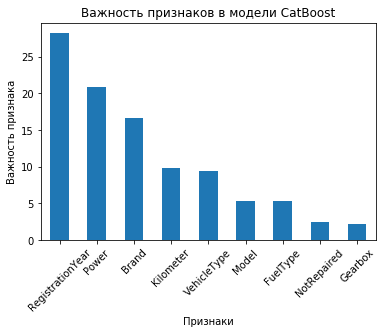

In [73]:
fimpcat = round(pd.Series(catmodel.feature_importances_, index = Xc_train.columns), 4)
    
fimpcat = fimpcat.sort_values(ascending = False)

fimpcat.plot(kind = 'bar')
plt.title("Важность признаков в модели CatBoost")
plt.xlabel("Признаки")
plt.ylabel("Важность признака")
plt.xticks(rotation = 45);

Наиболее значимые признаки - снова год регистрации и мощность авто, но модель CatBoost придает большую важность бренду (а LightGBM - модели автомобиля). 

## Анализ моделей

- Самый плохой результат показала модель линейной регрессии: из-за большого количества признаков, полученного в результате кодирования категориальных признаков (прежде всего, модели авто) модель обучается слишком долго (около часа). 


- Использование стохастического градиентного спуска позволяет снизить время обучения линейной регрессии до минуты, но результат остается таким же плохим: RMSE примерно на 1000 выше, чем у других моделей. Похоже, алгоритм линейной регрессии не подходит для нашей задачи.


- Случайный лес справляется с задачей гораздо лучше. При максимальной глубине дерева 27 модель дает RMSE около 1573 на кросс-валидации и около 1517 на тестовой выборке. Время обучения, с учетом подбора гиперпараметра, составляет около 8 минут.


- Обучили модели градиентного бустинга с использованием библиотек LightGBM и CatBoost. Обучение моделей занимает 12-14 минут, первая модель (LightGBM) показала результат чуть лучше: RMSE около 1472 на кросс-валидации и около 1428 на тестовой выборке.


- Таким образом, наилучший результат дает градиентный бустинг с использованием библиотеки LightGBM. При этом случайный лес дает сопоставимые результаты, но обучается заметно быстрее.


- При сопоставимых показателях качества на кросс-валидации и на тестовой выборке "под капотом" модели отличаются: важность разных признаков в разных моделях заметно отличается.

In [74]:
results = [['RandomForest', 1572, 1517, 6.57], ['LinearRegression', 2498, 2482, 53.3], \
           ['LightGBM', 1472, 1428, 14.37], ['CatBoost', 1234, 1455, 12.28]]
table = pd.DataFrame(results, columns = ['Model', 'RMSE (cv)', 'RMSE (test)', 'Time'])
table

,Model,RMSE (cv),RMSE (test),Time
0,RandomForest,1572,1517,6.57
1,LinearRegression,2498,2482,53.30
2,LightGBM,1472,1428,14.37
3,CatBoost,1234,1455,12.28
